actions:  2
state:  1


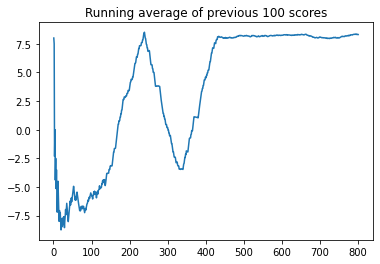

In [1]:
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt

from Envs import LineGoalEnv as L
import importlib
importlib.reload(L)


class Model(nn.Module):
    def __init__(self, dim_state, dim_action,h1, h2, alpha=1e-4 ):
        super(Model, self).__init__()
        
        self.dim_state = dim_state
        self.dim_action = dim_action
        
        self.linear1 = nn.Linear(dim_state, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2,dim_action)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)  #Output same number of the number of action values
        
        return output
    
    def save_CheckPoint(self):
        print ('...save check point...')
        torch.save(self.state_dict, self.checkpoint_file)
    def load_CheckPOint(self):
        print ('...load check point...')
        self.load_state_dict(torch.load(self.checkpoint_file))
        

class replayBuffer():
    def __init__(self,max_memsize, dim_state, dim_action):
        self.max_memsize = max_memsize
        self.counter = 0
        
        self.states_mem = np.zeros((max_memsize, dim_state), dtype=np.float32)
        self.states_mem_new = np.zeros((max_memsize, dim_state), dtype=np.float32)
        self.action_mem = np.zeros((max_memsize), dtype=np.int32)
        self.reward_mem = np.zeros(max_memsize, dtype=np.float32)
        self.done_mem = np.zeros(max_memsize, dtype=np.bool)        
        
    def store_transaction(self, state, action, reward, state_new, done):
        i = self.counter % self.max_memsize
        
        self.states_mem[i] = state
        self.action_mem[i] = action
        self.reward_mem[i] = reward
        self.done_mem[i]  =done
        self.states_mem_new[i] = state_new
        
        self.counter+=1
           
    def sample_buffer(self, batch_size):
        max_mem = min(self.counter, self.max_memsize)
        
        batch = np.random.choice(max_mem, batch_size, replace=False)

        state = self.states_mem[batch]
        action = self.action_mem[batch]
        reward = self.reward_mem[batch]
        state_new = self.states_mem_new[batch]
        done = self.done_mem[batch]
        
        return state, action, reward, state_new, done

class Agent():
    def __init__(self, env, dim_state, dim_action,h1, h2, max_memsize, alpha=1e-4, batch_size=258, max_iters = 30, epslon=0.05, 
                 steps_target=1000, gamma=0.99):

        self.batch_size = batch_size
        self.gamma = gamma
        self.max_iters = max_iters
        self.dim_action = dim_action
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.max_memsize = max_memsize
        self.epslon = epslon
        self.buffer = replayBuffer(max_memsize,dim_state, dim_action)
        self.loss_fun = nn.MSELoss()
        
        self.model = Model(dim_state, dim_action,h1, h2, alpha=1e-4 ).to(self.device)
        self.model_target = self.model
        self.steps_target = steps_target
        
    def select_actions_epsilon(self, best):
        if np.random.random() >= self.epslon:
            return best
        else:
            return np.random.choice(self.dim_action, 1)[0]  
        
    def plot_learning_curve(self,x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
        #plt.savefig(figure_file)
    
    def train(self):
        index = range(self.batch_size)
        self.model.train()
        rewards_list = []
        
        for i in range(self.max_iters):
            state = env.reset()
            done=False
            rewards = 0
            
            while not done:
                self.model.zero_grad()
                
                actions = self.model(torch.tensor(np.array(state).reshape(1,-1)).float())
                best = torch.argmax(actions)               
                action = self.select_actions_epsilon(best.item())
                
                state_new, reward, done, _ = env.step(action)
                rewards+=reward
                
                self.buffer.store_transaction(state, action, reward, state_new, done)
               
                if self.buffer.counter > self.batch_size:
                    state_batch, action_batch, reward_batch, state_new_batch, done_batch = self.buffer.sample_buffer(self.batch_size)

                    # Q value
                    q_values = self.model(torch.tensor(state_batch))[index, action_batch]
                    
                    # Target value
                    q_target_nexts = self.model_target(torch.tensor(state_new_batch))
                    q_target_nexts[done_batch] = 0.0
                    
                    q_target_next = torch.max(q_target_nexts, dim=1)[0]
                    q_targets = torch.tensor(reward_batch).to(self.device) + self.gamma * q_target_next
    
                    # Loss function
                    loss = self.loss_fun(q_targets,q_values)
                    loss.backward()
                    
                    # Update weights
                    self.model.optimizer.step()
        
                    #Update the state
                    state = state_new
                    if (self.buffer.counter % self.steps_target) == 0:
                        self.model_target = self.model 
            
            rewards_list.append(rewards)
            
        x = [i+1 for i in range(self.max_iters)]
        self.plot_learning_curve(x, rewards_list)
                
if __name__ == '__main__':
    
    ##Since for the discrete action, the convention is 0,1,2,3, need to convert action to same scale
    dim_action = 2
    dim_state = 1
    print('actions: ', dim_action)
    print('state: ', dim_state)
    
    env = L.CustomEnv()
    agent = Agent(env,dim_state,dim_action, 256, 256,max_memsize=3000, max_iters=800)
    agent.train()
        